In [18]:
import numpy as np
import torchio as tio

%load_ext autoreload
%autoreload 2

from mgmt.data.dataloader import DataModule

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from mgmt.data.subject_utils import get_subjects_from_batch
from mgmt.visualize.subject import plot_subject

from PIL import Image
import io
from mgmt.config import get_cfg
import os

from mgmt.model import build_model
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
filepath_npz = "/home/bryan/data/brain_tumor/caidm_3d_96/data.npz"
patient_exclusion_csv = "/home/bryan/src/mgmt-promoter-methylation/mgmt/data/patient_exclusion.csv"


In [11]:
expr_dir = "/home/bryan/expr/brain_tumor/2023-07-07/try2/run9"
cfg = get_cfg(os.path.join(expr_dir, "config.yaml"))
data_module = DataModule(cfg)
data_module.prepare_data()
data_module.setup()

/home/bryan/expr/brain_tumor/2023-07-07/try2/run9/config.yaml


2023-07-09 07:58:26.837 | INFO     | mgmt.data.dataloader:subjects_train_val_split:123 - 535 total subjects. 85.00% train/val ratio (455 train, 80 val)
2023-07-09 07:58:26.837 | INFO     | mgmt.data.dataloader:subjects_train_val_split:126 - val: (40 methylated, 40 unmethylated


In [37]:
data_module.train_set._transform = data_module.preprocess

In [14]:
model = build_model(cfg)


In [16]:
weights_fpath = os.path.join(expr_dir, "checkpoints/last.ckpt")

In [84]:
def load_weights(model, weights_fpath):
    ckpt_dict = torch.load(weights_fpath)
    state_dict = {
        key[len("net."):] : v for key,v in ckpt_dict["state_dict"].items()
    }
    model.load_state_dict(state_dict)
def get_subject_by_id(data_module, patient_id):
    for sub in data_module.subjects:
        if sub.patient_id == patient_id:
            return sub

In [63]:
load_weights(model, weights_fpath)
model.eval();

In [44]:
subject = data_module.train_set[11]

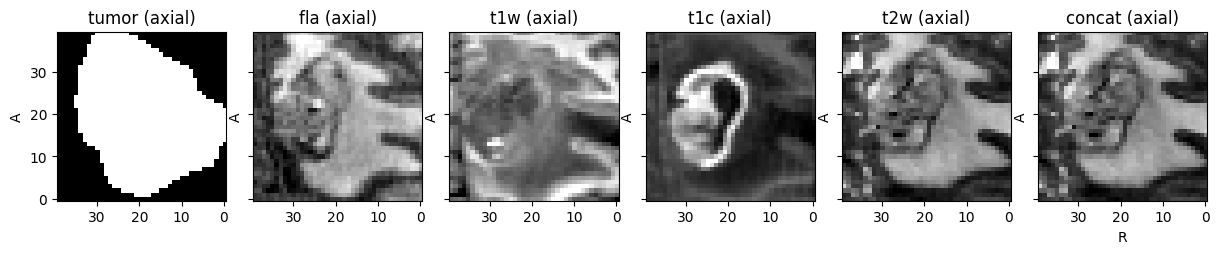

In [45]:
plot_subject(subject, show=True, single_axis="axial", figsize=(12, 4));

In [66]:
with torch.inference_mode():
    logits = model(subject.concat.tensor.unsqueeze(0))

In [68]:
model

ResNet(
  (conv1): Conv3d(4, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine

In [76]:
model.conv1.weight.shape

torch.Size([64, 4, 7, 7, 7])

In [71]:
model.conv1.weight[:,0,...].mean()

tensor(-0.0002, grad_fn=<MeanBackward0>)

In [72]:
model.conv1.weight[:,1,...].mean()

tensor(0.0065, grad_fn=<MeanBackward0>)

In [73]:
model.conv1.weight[:,2,...].mean()

tensor(0.0058, grad_fn=<MeanBackward0>)

In [74]:
model.conv1.weight[:,3,...].mean()

tensor(0.0006, grad_fn=<MeanBackward0>)

In [80]:
subject.concat.tensor.max()

tensor(1.4393)

In [85]:
orig_subject = get_subject_by_id(data_module, subject.patient_id)

In [86]:
orig_subject.concat.tensor.max()

tensor(4.)

In [ ]:
orig_subject.concat.tensor